PostId: 2019-06-04-103045
Title:てがしきのモデルを考える

モデルについてちょっと考えてみた自分向けメモ。

シンボルだけのモデルを使わないと今のデータセットでは無価値なオーバーフィットは避けられない。
ここではモデル側を工夫する路線を考えてみたい。

まず各シンボル自体はトレーニングセットがあるので学習出来る。
このモデルをSymと呼ぼう。Symはストロークデータを食わせると一文字のシンボルを返す。

これにアテンションをつけたい。
ストロークデータを並行移動し、マスクする感じのアテンションを前につければシンボルの識別器を使う事は出来そう。
ただ全データをRNNに食わせるとout of memoryなので、バッチでGPUで扱うには何かしらの工夫が要る。

問題は構造の所だ。
これは例えばシグマの下の式はしたつきでくっつく、みたいなの。
これを学習したい。

人間はどう考えるかといえば、シンボルと座標で分かりそうな気がする。
前のシンボルと、その占める矩形データがあって、今のシンボルが分かれば、下かどうかを判断出来る。
ただしこの前のシンボル、というのは、結構前な事がある。
直前とは限らない。
これは系列データとして扱う必要はあるだろう。

つまり、ストロークをシンボルと矩形データの系列に治すというネットワークと、シンボルと矩形データの系列からtexを生成する、という2つの問題を組み合わせたら良いんじゃないか。
これをSymRecと呼ぼう（SymbolとRect）。

ただ後者の問題はトレーニングデータが無い。
確か構造のデータはサブタスクであった気がするが、texとの対応がたぶん無いよなぁ。

SymRecはmany to manyのネットワークなのでTPUではどう作るか悩ましいなぁ。 
トレーニングセットも無いのでいい感じに学習してもらいたい。

アテンションについて考える。
ストロークデータのうち、今見てるシンボルの場所、を知るアテンションが要る。
これはシンボルだけのトレーニングセットの最大ストローク長より少し大きいくらいで良いだろう。

今見ているシンボル、を知るのに必要な情報は何か？
ほとんどは前のシンボルと矩形データだが、たまに結構前の矩形データが要る（シグマの下を処理してて、次にシグマの横に移る時）。

そう思うと、一つ前のシンボルと矩形データに、コンテキストがあれば良さそう。
これはシンボルと矩形データの系列から計算されるhにアテンションを入れた物、と解釈出来るか。
だからcausalなSymRecの結果にアテンションを入れた何かで、ストロークの列から対応する部分列を取り出す何かを作りたい。
windowみたいに縮めるネットワークって普通は何を使うんだろう？

概念的にはウィンドウサイズが決まってれば、先頭からのオフセットを決めてやればいいんだよな。
さらにそこにマスクがあれば良い。
サブストロークは可変にすると面倒なので決まったサイズを取ってくれば良いだろうから。
そう考えると学習すべきは先頭からのオフセットと長さの2つか。

そしてこの2つを元に系列を選びたいが、これでは微分可能にならないのでちょっと細工が要るか。

window sizeの位置をsoftmaxで返させて、convolutionすれば良いか。
なんかCNNのビルディングブロックでどうにか出来ないかな。

このストローク列から今処理してるストローク列を取り出すネットワークをSubStと呼ぼう。

ちょっと良くわからなくなってきたので全体の概要を書いてみる。

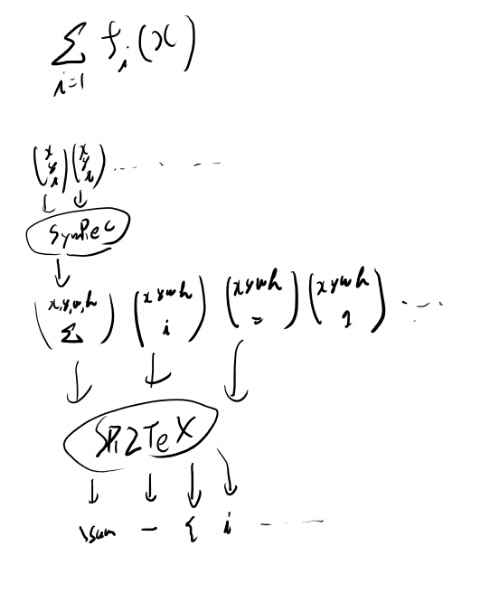

In [1]:
MeatPieImage()

こうして見ると、SR2TeXはちゃんと学習出来る気がする。
SymRecが学習データの制約からも難しい所だな。

### SymRecの動的なwindow的挙動（をどうするか）

でかい系列なのでそのままRNNに食わすとバッチではメモリを食いすぎて学習できない。
一方で本質的には、SymRecはいつもまだ処理してない先頭の方だけを局所的に見れば問題は解けるはずなので、そんなでかいデータを見る必要も無い。

例えば先頭100とかを決め打って、そこでシンボルとどこまでの点が対応するストロークかを返させれば良い。
で、その続きからまた次の100を見ればよい。
CPUならこれで良さそう。

ただこれでは学習はめっさ遅いのでGPU化する必要はありそう。
tf.condとかwhileとか使ってやれるかしら？
なんかちょっと考えたくらいだと、どうやったらいいかわからんが。

一晩たってかんがえたが、これは前処理としてinferenceとしてやるのが良いな。
まずシンボルのデータセットを複数つなげて、切れ目を予想するモデルを作る。